# Python/Kerasで深層学習：
# MNISTからGANで類似画像生成

https://github.com/keras-team/keras/blob/master/examples/mnist_acgan.py

<pre>
Train an Auxiliary Classifier Generative Adversarial Network (ACGAN) on the
MNIST dataset. See https://arxiv.org/abs/1610.09585 for more details.
You should start to see reasonable images after ~5 epochs, and good images
by ~15 epochs. You should use a GPU, as the convolution-heavy operations are
very slow on the CPU. Prefer the TensorFlow backend if you plan on iterating,
as the compilation time can be a blocker using Theano.
Timings:
Hardware           | Backend | Time / Epoch
-------------------------------------------
 CPU               | TF      | 3 hrs
 Titan X (maxwell) | TF      | 4 min
 Titan X (maxwell) | TH      | 7 min
Consult https://github.com/lukedeo/keras-acgan for more information and
example output
</pre>

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3  
session = tf.Session(config=config)
import keras
from keras import backend as K
K.set_session(session) 

Using TensorFlow backend.


In [2]:
from collections import defaultdict
try:
    import cPickle as pickle
except ImportError:
    import pickle
from PIL import Image

from six.moves import range

from keras.datasets import mnist
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
import numpy as np

np.random.seed(1337)
num_classes = 10


In [3]:
def build_generator(latent_size):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., 28, 28, 1)
    cnn = Sequential()

    cnn.add(Dense(3 * 3 * 384, input_dim=latent_size, activation='relu'))
    cnn.add(Reshape((3, 3, 384)))

    # upsample to (7, 7, ...)
    cnn.add(Conv2DTranspose(192, 5, strides=1, padding='valid',
                            activation='relu',
                            kernel_initializer='glorot_normal'))
    cnn.add(BatchNormalization())

    # upsample to (14, 14, ...)
    cnn.add(Conv2DTranspose(96, 5, strides=2, padding='same',
                            activation='relu',
                            kernel_initializer='glorot_normal'))
    cnn.add(BatchNormalization())

    # upsample to (28, 28, ...)
    cnn.add(Conv2DTranspose(1, 5, strides=2, padding='same',
                            activation='tanh',
                            kernel_initializer='glorot_normal'))

    # this is the z space commonly referred to in GAN papers
    latent = Input(shape=(latent_size, ))

    # this will be our label
    image_class = Input(shape=(1,), dtype='int32')

    cls = Flatten()(Embedding(num_classes, latent_size,
                              embeddings_initializer='glorot_normal')(image_class))

    # hadamard product between z-space and a class conditional embedding
    h = layers.multiply([latent, cls])

    fake_image = cnn(h)

    return Model([latent, image_class], fake_image)


In [4]:
def build_discriminator():
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = Sequential()

    cnn.add(Conv2D(32, 3, padding='same', strides=2,
                   input_shape=(28, 28, 1)))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(64, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(128, 3, padding='same', strides=2))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(256, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Flatten())

    image = Input(shape=(28, 28, 1))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation')(features)
    aux = Dense(num_classes, activation='softmax', name='auxiliary')(features)

    return Model(image, [fake, aux])



In [5]:
# batch and latent size taken from the paper
epochs = 100
batch_size = 100
latent_size = 100

# Adam parameters suggested in https://arxiv.org/abs/1511.06434
adam_lr = 0.0002
adam_beta_1 = 0.5

In [6]:
# build the discriminator
print('Discriminator model:')
discriminator = build_discriminator()
discriminator.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)
discriminator.summary()

Discriminator model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 12544)        387840      input_1[0][0]                    
__________________________________________________________________________________________________
generation (Dense)              (None, 1)            12545       sequential_1[1][0]               
__________________________________________________________________________________________________
auxiliary (Dense)               (None, 10)           125450      sequential_1[1][0]               
Total params: 525,835
Trainable params: 525,835
Non-trainable params: 0
________________

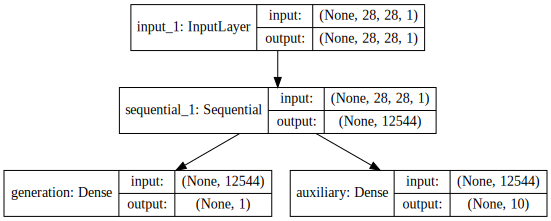

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.utils.vis_utils import plot_model
plot_model(discriminator, show_shapes=True, to_file='Python-MNIST-GAN-Discriminator.jpg')

SVG(model_to_dot(discriminator,show_shapes=True).create(prog='dot', format='svg'))

In [8]:
# build the generator
generator = build_generator(latent_size)

latent = Input(shape=(latent_size, ))
image_class = Input(shape=(1,), dtype='int32')

# get a fake image
fake = generator([latent, image_class])

# we only want to be able to train generation for the combined model
discriminator.trainable = False
fake, aux = discriminator(fake)
combined = Model([latent, image_class], [fake, aux])

print('Combined model:')
combined.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)
combined.summary()

Combined model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 28, 28, 1)    2657897     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 1), (None, 1 525835      model_2[1][0]               

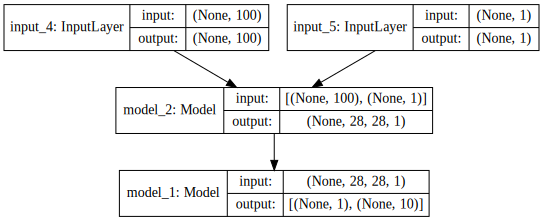

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.utils.vis_utils import plot_model
plot_model(combined, show_shapes=True, to_file='Python-MNIST-GAN-Combined.jpg')

SVG(model_to_dot(combined,show_shapes=True).create(prog='dot', format='svg'))

In [10]:
# get our mnist data, and force it to be of shape (..., 28, 28, 1) with
# range [-1, 1]
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

x_test = (x_test.astype(np.float32) - 127.5) / 127.5
x_test = np.expand_dims(x_test, axis=-1)

num_train, num_test = x_train.shape[0], x_test.shape[0]

train_history = defaultdict(list)
test_history = defaultdict(list)

print(x_train.shape[0], '訓練データ数')
print(x_test.shape[0], 'テストデータ数')


60000 訓練データ数
10000 テストデータ数


In [ ]:
    for epoch in range(1, epochs + 1):
        print('Epoch {}/{}'.format(epoch, epochs))

        num_batches = int(x_train.shape[0] / batch_size)
        progress_bar = Progbar(target=num_batches)

        # we don't want the discriminator to also maximize the classification
        # accuracy of the auxiliary classifier on generated images, so we
        # don't train discriminator to produce class labels for generated
        # images (see https://openreview.net/forum?id=rJXTf9Bxg).
        # To preserve sum of sample weights for the auxiliary classifier,
        # we assign sample weight of 2 to the real images.
        disc_sample_weight = [np.ones(2 * batch_size),
                              np.concatenate((np.ones(batch_size) * 2,
                                              np.zeros(batch_size)))]

        epoch_gen_loss = []
        epoch_disc_loss = []

        for index in range(num_batches):
            # generate a new batch of noise
            noise = np.random.uniform(-1, 1, (batch_size, latent_size))

            # get a batch of real images
            image_batch = x_train[index * batch_size:(index + 1) * batch_size]
            label_batch = y_train[index * batch_size:(index + 1) * batch_size]

            # sample some labels from p_c
            sampled_labels = np.random.randint(0, num_classes, batch_size)

            # generate a batch of fake images, using the generated labels as a
            # conditioner. We reshape the sampled labels to be
            # (batch_size, 1) so that we can feed them into the embedding
            # layer as a length one sequence
            generated_images = generator.predict(
                [noise, sampled_labels.reshape((-1, 1))], verbose=0)

            x = np.concatenate((image_batch, generated_images))

            # use one-sided soft real/fake labels
            # Salimans et al., 2016
            # https://arxiv.org/pdf/1606.03498.pdf (Section 3.4)
            soft_zero, soft_one = 0, 0.95
            y = np.array([soft_one] * batch_size + [soft_zero] * batch_size)
            aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

            # see if the discriminator can figure itself out...
            epoch_disc_loss.append(discriminator.train_on_batch(
                x, [y, aux_y], sample_weight=disc_sample_weight))

            # make new noise. we generate 2 * batch size here such that we have
            # the generator optimize over an identical number of images as the
            # discriminator
            noise = np.random.uniform(-1, 1, (2 * batch_size, latent_size))
            sampled_labels = np.random.randint(0, num_classes, 2 * batch_size)

            # we want to train the generator to trick the discriminator
            # For the generator, we want all the {fake, not-fake} labels to say
            # not-fake
            trick = np.ones(2 * batch_size) * soft_one

            epoch_gen_loss.append(combined.train_on_batch(
                [noise, sampled_labels.reshape((-1, 1))],
                [trick, sampled_labels]))

            progress_bar.update(index + 1)

        print('Testing for epoch {}:'.format(epoch))

        # evaluate the testing loss here

        # generate a new batch of noise
        noise = np.random.uniform(-1, 1, (num_test, latent_size))

        # sample some labels from p_c and generate images from them
        sampled_labels = np.random.randint(0, num_classes, num_test)
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=False)

        x = np.concatenate((x_test, generated_images))
        y = np.array([1] * num_test + [0] * num_test)
        aux_y = np.concatenate((y_test, sampled_labels), axis=0)

        # see if the discriminator can figure itself out...
        discriminator_test_loss = discriminator.evaluate(
            x, [y, aux_y], verbose=False)

        discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

        # make new noise
        noise = np.random.uniform(-1, 1, (2 * num_test, latent_size))
        sampled_labels = np.random.randint(0, num_classes, 2 * num_test)

        trick = np.ones(2 * num_test)

        generator_test_loss = combined.evaluate(
            [noise, sampled_labels.reshape((-1, 1))],
            [trick, sampled_labels], verbose=False)

        generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

        # generate an epoch report on performance
        train_history['generator'].append(generator_train_loss)
        train_history['discriminator'].append(discriminator_train_loss)

        test_history['generator'].append(generator_test_loss)
        test_history['discriminator'].append(discriminator_test_loss)

        print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
            'component', *discriminator.metrics_names))
        print('-' * 65)

        ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.4f} | {3:<5.4f}'
        print(ROW_FMT.format('generator (train)',
                             *train_history['generator'][-1]))
        print(ROW_FMT.format('generator (test)',
                             *test_history['generator'][-1]))
        print(ROW_FMT.format('discriminator (train)',
                             *train_history['discriminator'][-1]))
        print(ROW_FMT.format('discriminator (test)',
                             *test_history['discriminator'][-1]))

        # save weights every epoch
        generator.save_weights(
            'params_generator_epoch_{0:03d}.hdf5'.format(epoch), True)
        discriminator.save_weights(
            'params_discriminator_epoch_{0:03d}.hdf5'.format(epoch), True)

        # generate some digits to display
        num_rows = 40
        noise = np.tile(np.random.uniform(-1, 1, (num_rows, latent_size)),
                        (num_classes, 1))

        sampled_labels = np.array([
            [i] * num_rows for i in range(num_classes)
        ]).reshape(-1, 1)

        # get a batch to display
        generated_images = generator.predict(
            [noise, sampled_labels], verbose=0)

        # prepare real images sorted by class label
        real_labels = y_train[(epoch - 1) * num_rows * num_classes:
                              epoch * num_rows * num_classes]
        indices = np.argsort(real_labels, axis=0)
        real_images = x_train[(epoch - 1) * num_rows * num_classes:
                              epoch * num_rows * num_classes][indices]

        # display generated images, white separator, real images
        img = np.concatenate(
            (generated_images,
             np.repeat(np.ones_like(x_train[:1]), num_rows, axis=0),
             real_images))

        # arrange them into a grid
        img = (np.concatenate([r.reshape(-1, 28)
                               for r in np.split(img, 2 * num_classes + 1)
                               ], axis=-1) * 127.5 + 127.5).astype(np.uint8)

        Image.fromarray(img).save(
            'plot_epoch_{0:03d}_generated.png'.format(epoch))


Epoch 1/100


C:\Anaconda3\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


504/600 [========================>.....] - ETA: 8:45

In [12]:
with open('acgan-history.pkl', 'wb') as f:
    pickle.dump({'train': train_history, 'test': test_history}, f)


In [13]:
# Matplotlibのフォントの制御（大きさや種類）
%matplotlib inline
import numpy as np # Numpy
import matplotlib
import matplotlib.pyplot as plt # 描画ライブラリ
print (matplotlib.rcParams.get('font.family'))
import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects

font_prop = fm.FontProperties()  
font_prop.set_style('normal')
font_prop.set_weight('light')
font_prop.set_size('12')

fp2 = font_prop.copy()# フォントプロパティ(FP)をコピー
fp2.set_size('20')# フォントプロパティ(FP)をコピー
fp2.set_family('serif')# フォントはSerif(明朝体など）に設定

['sans-serif']


In [ ]:
'''
train_history['generator'].append(generator_train_loss)
train_history['discriminator'].append(discriminator_train_loss)

test_history['generator'].append(generator_test_loss)
test_history['discriminator'].append(discriminator_test_loss)
'''

In [21]:
hr_g = train_history['generator']
hr_d = train_history['discriminator']
ht_g = test_history['generator']
ht_d = test_history['discriminator']
print(type(x), len(x)) # array([1.3826841 , 0.96553123, 0.41715324], dtype=float32)...

n = len(x)
#print(hr_g[0][0], hr_g[0][1])

tr_generator_loss = np.zeros([n], dtype=float)
tr_generator_val_loss = np.zeros([n], dtype=float)
tr_generator_aux_loss = np.zeros([n], dtype=float)
tr_discriminator_loss = np.zeros([n], dtype=float)
tr_discriminator_val_loss = np.zeros([n], dtype=float)
tr_discriminator_aux_loss = np.zeros([n], dtype=float)
te_generator_loss = np.zeros([n], dtype=float)
te_generator_val_loss = np.zeros([n], dtype=float)
te_generator_aux_loss = np.zeros([n], dtype=float)
te_discriminator_loss = np.zeros([n], dtype=float)
te_discriminator_val_loss = np.zeros([n], dtype=float)
te_discriminator_aux_loss = np.zeros([n], dtype=float)

for i in range(n):
    tr_generator_loss[i] = hr_g[i][0]
    tr_generator_val_loss[i] = hr_g[i][1]
    tr_generator_aux_loss[i] = hr_g[i][2]
    tr_discriminator_loss[i] = hr_d[i][0]
    tr_discriminator_val_loss[i] = hr_d[i][1]
    tr_discriminator_aux_loss[i] = hr_d[i][2]
    te_generator_loss[i] = ht_g[i][0]
    te_generator_val_loss[i] = ht_g[i][1]
    te_generator_aux_loss[i] = ht_g[i][2]
    te_discriminator_loss[i] = ht_d[i][0]
    te_discriminator_val_loss[i] = ht_d[i][1]
    te_discriminator_aux_loss[i] = ht_d[i][2]
    

<class 'list'> 100


In [24]:
x_axis = np.zeros([100],dtype=int)
for i in range(len(x_axis)):
    x_axis[i] = i+1
print(x_axis)
#x_axis = x_axis[1:]


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


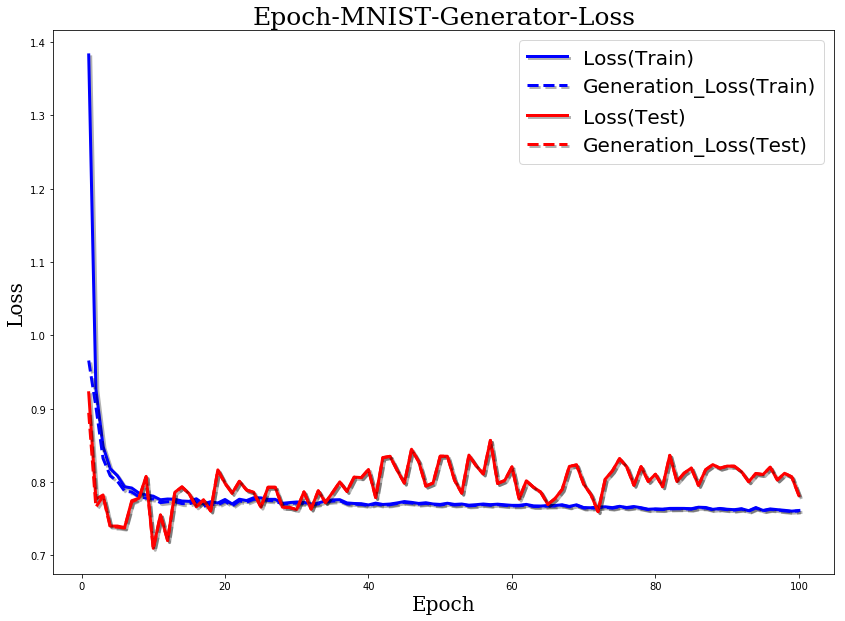

In [29]:
# 損失グラフの描画　% matplotlib inline
plt.figure(figsize=(14,10))

plt.plot(x_axis, tr_generator_loss, 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(x_axis, tr_generator_val_loss, 
         color='b', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
#plt.plot(x_axis, tr_generator_aux_loss, 
#         color='b', 
#         linestyle=':',
#         linewidth=3,
#         path_effects=[path_effects.SimpleLineShadow(),
#                       path_effects.Normal()])

plt.plot(x_axis, te_generator_loss, 
         color='r', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(x_axis, te_generator_val_loss, 
         color='r', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
#plt.plot(x_axis, te_generator_aux_loss, 
#         color='r', 
#         linestyle=':',
#         linewidth=3,
#         path_effects=[path_effects.SimpleLineShadow(),
#                       path_effects.Normal()])

plt.title('Epoch-MNIST-Generator-Loss',fontsize=25,font_properties=fp2)
plt.ylabel('Loss',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch',fontsize=20,font_properties=fp2)
plt.legend(['Loss(Train)', 'Generation_Loss(Train)', #'Aux_Loss(Train)',
           'Loss(Test)', 'Generation_Loss(Test)'], #, 'Aux_Loss(Test)'], 
           loc='best', fontsize=20)
plt.savefig('Epoch-MNIST-Generator-Loss.pdf')
plt.show()

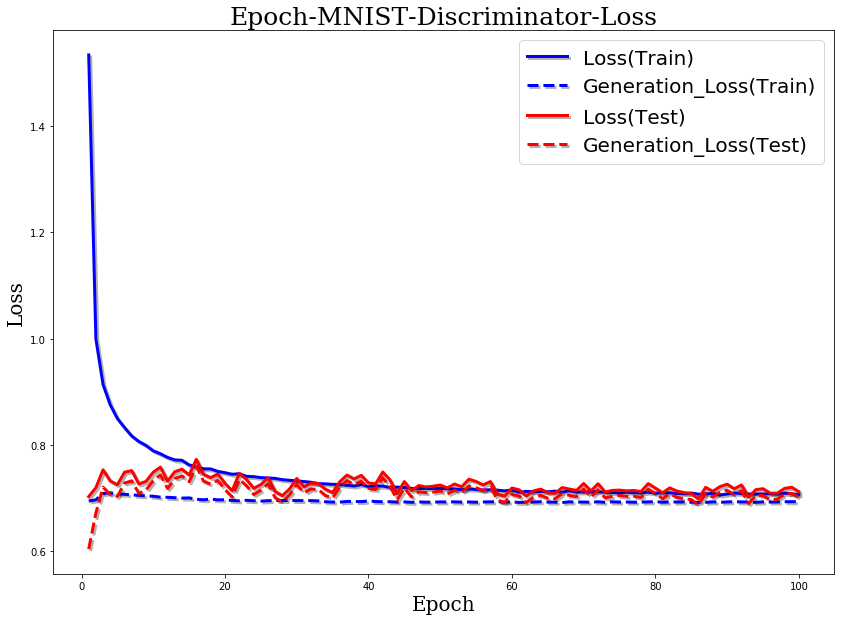

In [30]:
# 損失グラフの描画　% matplotlib inline
plt.figure(figsize=(14,10))

plt.plot(x_axis, tr_discriminator_loss, 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(x_axis, tr_discriminator_val_loss, 
         color='b', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
#plt.plot(x_axis, tr_discriminator_aux_loss, 
#         color='b', 
#         linestyle=':',
#         linewidth=3,
#         path_effects=[path_effects.SimpleLineShadow(),
#                       path_effects.Normal()])

plt.plot(x_axis, te_discriminator_loss, 
         color='r', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(x_axis, te_discriminator_val_loss, 
         color='r', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
#plt.plot(x_axis, te_discriminator_aux_loss, 
#         color='r', 
#         linestyle=':',
#         linewidth=3,
#         path_effects=[path_effects.SimpleLineShadow(),
#                       path_effects.Normal()])

plt.title('Epoch-MNIST-Discriminator-Loss',fontsize=25,font_properties=fp2)
plt.ylabel('Loss',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch',fontsize=20,font_properties=fp2)
plt.legend(['Loss(Train)', 'Generation_Loss(Train)', #'Aux_Loss(Train)',
           'Loss(Test)', 'Generation_Loss(Test)'], #, 'Aux_Loss(Test)'], 
           loc='best', fontsize=20)
plt.savefig('Epoch-MNIST-Discriminator-Loss.pdf')
plt.show()

左：生成（偽者）、右：元画像


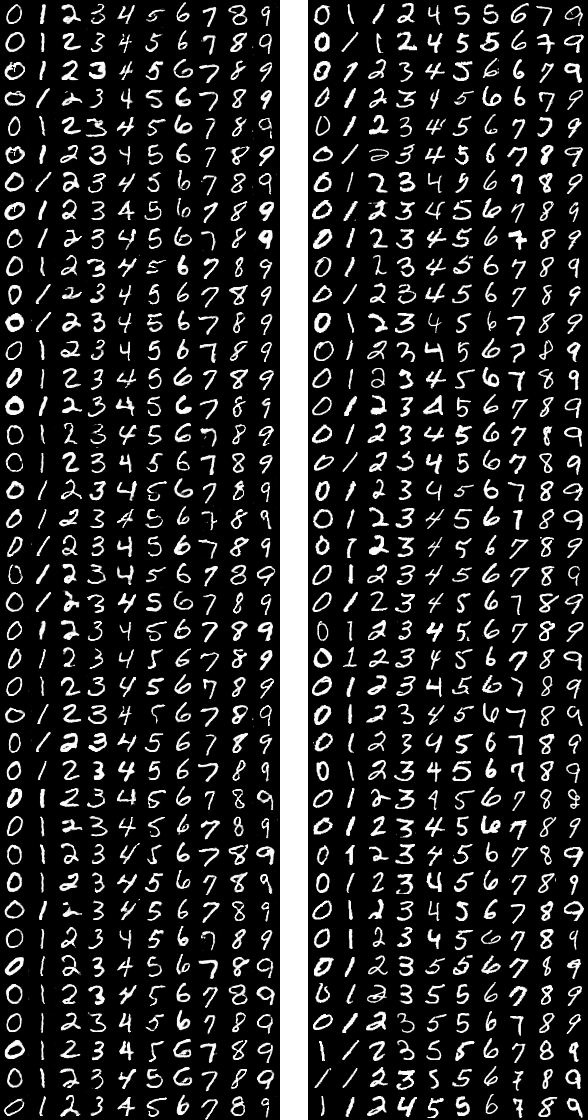

In [49]:
from IPython.display import Image
print("左：生成（偽者）、右：元画像")
Image("png/plot_epoch_060_generated.png",width="400")